# Import needed modules

In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define root data directory
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/'

# Define lung and colon classes with the appropriate sub-directory structure
sub_dirs = {
    'colon_image_sets': ['colon_aca', 'colon_n'],
    'lung_image_sets': ['lung_aca', 'lung_n', 'lung_scc']
}

# Initialize lists for filepaths and labels
filepaths = []
labels = []

# Populate filepaths and labels based on the folder structure for both lung and colon classes
for parent_dir, sub_classes in sub_dirs.items():
    for sub_class in sub_classes:
        class_path = os.path.join(data_dir, parent_dir, sub_class)
        if os.path.exists(class_path):
            files = os.listdir(class_path)
            for file in files:
                filepaths.append(os.path.join(class_path, file))
                labels.append(sub_class)

# Create a DataFrame with filepaths and labels
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

#### **Functions to check data splitting format**

In [17]:
train_df, temp_df = train_test_split(df, train_size=0.8, stratify=df['labels'], random_state=42)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, stratify=temp_df['labels'], random_state=42)

# Label mapping
label_mapping = {label: idx for idx, label in enumerate(df['labels'].unique())}

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}


#### **Function to split data into train, valid, test**

In [18]:
class CancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        label_idx = label_mapping[label]
        return image, label_idx

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and data loaders
train_dataset = CancerDataset(train_df, transform=transform)
valid_dataset = CancerDataset(valid_df, transform=transform)
test_dataset = CancerDataset(test_df, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
num_classes = len(label_mapping)
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [26]:
num_epochs = 2
# for epoch in range(num_epochs):
#     train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#     val_loss, val_acc, _, _ = evaluate(model, valid_loader, criterion, device)

#     print(f"Epoch {epoch+1}/{num_epochs}")
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
#     print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%")
#     print("-" * 60)

# Test the model
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc * 100:.2f}%")

Test Loss: 0.0727 | Test Accuracy: 97.12%


#### Function to generate images from dataframe

Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.99      0.99      0.99       500
     colon_n       1.00      1.00      1.00       500
    lung_aca       0.91      0.97      0.94       500
      lung_n       0.99      1.00      1.00       500
    lung_scc       0.98      0.90      0.94       500

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



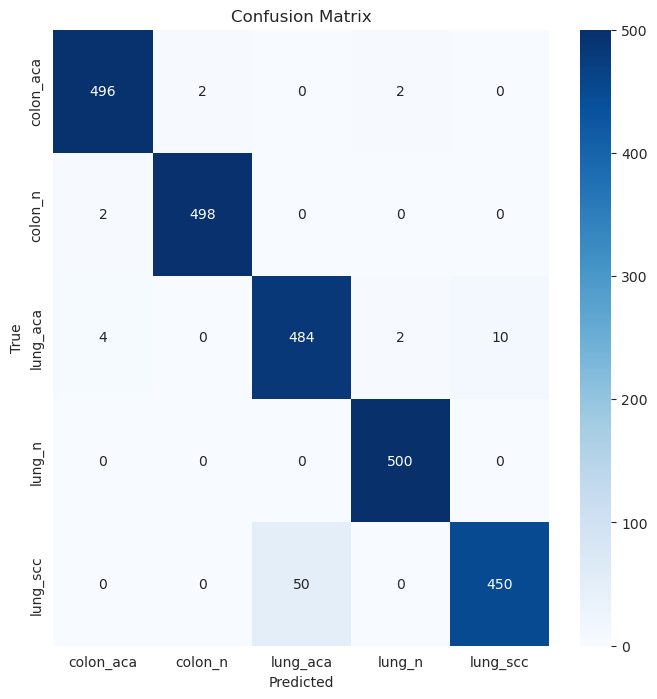

In [27]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### **Function to display data sample**

In [28]:
model_save_path = '/kaggle/working/lung_cancer_model.pth'  # or '/kaggle/working/lung_colon_model.pth' in the other notebook

# Assuming your model is called `model`
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/lung_cancer_model.pth
